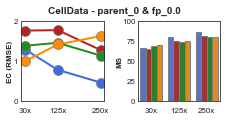

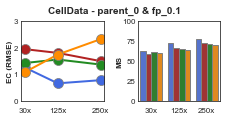

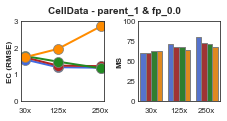

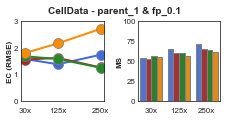

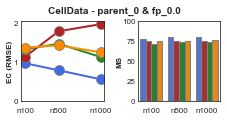

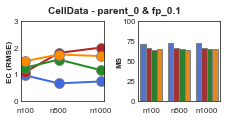

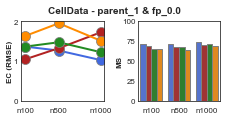

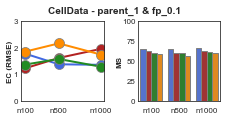

In [1]:
import numpy as np 
import pandas as pd
import os, glob, math
import matplotlib 
matplotlib.rcParams["font.family"] = 'arial'
import palettable
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

for subdir in ["by_depth", "by_fpratio", "by_numclone", "by_numblock", "by_nummutation",  "proportions", "with_simpleKmeans", "Sex_chromosome"]:
    OUTPUT_DIR = "/data/project/Alzheimer/YSscript/cle/Revision/" + str (subdir)
    if os.path.exists(OUTPUT_DIR) == False:
        os.system("mkdir -p " + OUTPUT_DIR)

def drawfigure (long_df, x, title, saveloc ):
    tabl = palettable.tableau.Tableau_20.mpl_colors
    safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors

    #colorlist = [i for i in safe7]
    colorlist = ["royalblue", "firebrick", "forestgreen", "darkorange", Gr_10[6], Gr_10[5], Gr_10[4]]
    sns.set_style("white")
    #sns.set_palette("tab10")
    sns.set_palette(sns.color_palette(colorlist))


    # Create a grouped bar graph
    fig, ax = plt.subplots( nrows = 1, ncols = 2, figsize =  (7.8 / 2.54, 4 / 2.54))
    fig.subplots_adjust ( wspace = 0.4, bottom = 0.15, top = 0.85, left = 0.08, right = 0.98)
    

    sns.lineplot(data = long_df, x = x, y = 'EC', hue = 'tool', 
                    linewidth = 2, marker = 'o',  markersize = 10, markeredgecolor = "gray", 
                    err_style = "band", errorbar=('ci', 95), ax = ax[0])
    ax[0].set_xlabel( None )
    ax[0].set_ylabel( "EC (RMSE)", fontsize = 8, fontweight = "semibold" )
    ax[0].yaxis.set_label_coords( -0.10, 0.5)   # 왼쪽으로 살짝 이동

    ax[0].set_xticks ( sorted(list ( set(long_df[x])) ) ) 
    ax[0].legend_.remove()
    if x == "DEPTH_MEAN":
        ax[0].set_xticklabels ( [ str(i) + str ("x") for i in sorted( list ( set(long_df[x]) ) ) ] , fontsize = 8, fontweight = "normal"  ) 
    if x == "NUM_MUTATION":
        ax[0].set_xticklabels ( [ str("n") + str(i)  for i in sorted( list ( set(long_df[x]) ) ) ] , fontsize = 8, fontweight = "normal" ) 
    if x == "FP_RATIO":
        ax[0].set_xticklabels ( [ str(i * 100) + str ("%") for i in sorted( list ( set(long_df[x]) ) ) ] , fontsize = 8, fontweight = "normal" ) 
        ax[0].tick_params(axis = 'x', rotation = 30, pad = -2.2)
    ax[0].set_yticks ( np.arange (0, math.ceil (max(long_df["EC"])) + 0.1, 1).astype(int) )
    ax[0].tick_params(axis = 'y', pad = 0) 
    ax[0].set_yticklabels ( ax[0].get_yticks(), fontsize = 8, fontweight = "normal")

    #ax[0].legend ( title = None, labels = ["CLEMENT", "pyclone", "sciclone", "qc"] )


    sns.barplot(data = long_df, x = x, y = 'MS', hue = 'tool', 
                    linewidth = 1, edgecolor='gray', 
                    dodge = True,
                    ax = ax[1])
    ax[1].set_xlabel( None )
    ax[1].set_ylabel( "MS", fontsize = 8, fontweight = "semibold" )
    ax[1].yaxis.set_label_coords( -0.18, 0.5)   # ylabel을 왼쪽으로 살짝 이동

    ax[1].legend_.remove()
    if x == "DEPTH_MEAN":
        ax[1].set_xticklabels ( [ str(i) + str ("x") for i in sorted( list ( set(long_df[x]) ) ) ] , fontsize = 8, fontweight = "normal" ) 
    if x == "NUM_MUTATION":
        ax[1].set_xticklabels ( [ str("n") + str(i)  for i in sorted( list ( set(long_df[x]) ) ) ] , fontsize = 8, fontweight = "normal" ) 
    if x == "FP_RATIO":
        ax[1].set_xticklabels ( [ str(i * 100) + str ("%") for i in sorted( list ( set(long_df[x]) ) ) ] , fontsize = 8, fontweight = "normal" ) 
        ax[1].tick_params(axis = 'x', rotation = 30, pad = -2.2)    
    # ax[1].set_ylim( [0, 100.1] )
    # ax[1].set_yticks ( np.linspace (0, 100.1, 6) ) 
    ax[1].set_yticks ( np.arange (0, math.ceil (max(long_df["MS"]) / 100) * 100 + 1, 25) )
    ax[1].tick_params(axis = 'y', pad = -1.5) 
    ax[1].set_yticklabels ( ax[1].get_yticks(), fontsize = 8, fontweight = "normal")

    plt.suptitle( title , fontsize = 10, y = 0.98, fontweight = "semibold" )
    #fig.text (x = 0.5, y = 0.02, ha = "center", s = "{}".format( x ), fontsize = 10, fontweight = "semibold")

    plt.savefig ( saveloc, dpi = 300 )
    plt.show()

    
    # # Create Figure 2 for the legend
    # fig_legend, ax_legend = plt.subplots( nrows = 1, ncols = 1, figsize = (12, 1) )

    # # Extract the legend from Figure 1 and add it to Figure 2
    # ax_legend.add_artist( legend_s )
    # sns.despine(ax=ax_legend, left=True, right=True, top=True, bottom=True)
    # ax_legend.set_xticks([])
    # ax_legend.set_yticks([])
    # ax_legend.set_xlabel( None )
    # ax_legend.set_ylabel( None )

    # # Show or save Figure 2
    # plt.show()



def bm_by_depth ( NUM_BLOCK_LIST, NUM_MUTATION_LIST, DEPTH_MEAN_LIST, NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST):
    #toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone"]

    for NUM_PARENT in NUM_PARENT_LIST:        
        for FP_RATIO in FP_RATIO_LIST:
            for AXIS_RATIO in AXIS_RATIO_LIST:        
                long_df = pd.DataFrame ( columns = ["DEPTH_MEAN", "NUM_BLOCK", "NUM_MUTATION", "NUM_PARENT", "FP_RATIO", "AXIS_RATIO", "tool", "MS", "EC"] )
            
                for DEPTH_MEAN in DEPTH_MEAN_LIST:
                    for NUM_BLOCK in NUM_BLOCK_LIST:
                        for NUM_MUTATION in NUM_MUTATION_LIST:
                            INPUT_DIR_LIST = sorted ( glob.glob ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/2.CellData/CellData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN) + "x/parent_" + str (NUM_PARENT) + "/fp_" + str(FP_RATIO) + "/axis_" + str(AXIS_RATIO) + "/BM_FINAL.tsv") )

                            for INPUT_DIR in INPUT_DIR_LIST:
                                if not os.path.exists ( INPUT_DIR ):
                                    print (INPUT_DIR + "없음")
                                    continue
                                    
                                df = pd.read_csv (INPUT_DIR , sep = "\t", header = None, index_col = 0)
                                for tool in toollist:
                                    long_df.loc[len(long_df.index)] = [ DEPTH_MEAN, NUM_BLOCK, NUM_MUTATION, NUM_PARENT, FP_RATIO, AXIS_RATIO, tool, df.loc [tool][1], df.loc [tool][3] ]   # 맨 끝에 하나씩 추가

                long_df["MS"] = long_df["MS"] * (100 / long_df["NUM_MUTATION"])     # 100점 만점으로 normalize    
                drawfigure (long_df, 'DEPTH_MEAN', "CellData - parent_{} & fp_{}".format (NUM_PARENT, FP_RATIO, AXIS_RATIO), "/data/project/Alzheimer/YSscript/cle/Revision/by_depth/2.CellData-bydepth_parent_{}_{}.pdf".format (NUM_PARENT, FP_RATIO))

                # tsv로 정리해서 저장하기
                tt = pd.concat ( [  round (long_df.groupby (["DEPTH_MEAN", "tool"])["EC"].mean() , 2), round (long_df.groupby (["DEPTH_MEAN", "tool"])["MS"].mean() , 2)] , axis = 1)
                tt.columns = ["RMSE_mean", "MS_mean"]
                tt = tt.astype ( {"RMSE_mean" : "str", "MS_mean" : "str"})
                k = 0
                while k < tt.shape[0]:
                    MS_ratio =  [ float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+1]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+2]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+3]["MS_mean"]) ]
                    tt.iloc[k, 1] = tt.iloc[k]["MS_mean"] + " ({}-{}% ↑)".format ( round ( min (MS_ratio) * 100, 1), round ( max (MS_ratio) * 100, 1) )
                    k += len(toollist)
                tt.to_csv ( "/data/project/Alzheimer/YSscript/cle/Revision/by_depth/2.CellData-bydepth_parent_{}_{}.tsv".format (NUM_PARENT, FP_RATIO),  sep = "\t", index = True)

    return long_df

def bm_by_nummutation ( NUM_BLOCK_LIST, NUM_MUTATION_LIST, DEPTH_MEAN_LIST, NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST):

    for NUM_PARENT in NUM_PARENT_LIST:        
        for FP_RATIO in FP_RATIO_LIST:
            for AXIS_RATIO in AXIS_RATIO_LIST:        
                long_df = pd.DataFrame ( columns = ["DEPTH_MEAN", "NUM_BLOCK", "NUM_MUTATION", "NUM_PARENT", "FP_RATIO", "AXIS_RATIO", "tool", "MS", "EC"] )
            
                for DEPTH_MEAN in DEPTH_MEAN_LIST:
                    for NUM_BLOCK in NUM_BLOCK_LIST:
                        for NUM_MUTATION in NUM_MUTATION_LIST:
                            INPUT_DIR_LIST = sorted ( glob.glob ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/2.CellData/CellData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN) + "x/parent_" + str (NUM_PARENT) + "/fp_" + str(FP_RATIO) + "/axis_" + str(AXIS_RATIO) + "/BM_FINAL.tsv") )

                            for INPUT_DIR in INPUT_DIR_LIST:
                                if not os.path.exists ( INPUT_DIR ):
                                    print (INPUT_DIR + "없음")
                                    continue

                                df = pd.read_csv (INPUT_DIR , sep = "\t", header = None, index_col = 0)
                                for tool in toollist:
                                    long_df.loc[len(long_df.index)] = [ DEPTH_MEAN, NUM_BLOCK, NUM_MUTATION, NUM_PARENT, FP_RATIO, AXIS_RATIO, tool, df.loc [tool][1], df.loc [tool][3] ]   # 맨 끝에 하나씩 추가
                    
                long_df["MS"] = long_df["MS"] * (100 / long_df["NUM_MUTATION"])     # 100점 만점으로 normalize
                drawfigure (long_df, 'NUM_MUTATION', "CellData - parent_{} & fp_{}".format (NUM_PARENT, FP_RATIO), "/data/project/Alzheimer/YSscript/cle/Revision/by_nummutation/2.CellData-bynummutation_parent_{}_{}.pdf".format (NUM_PARENT, FP_RATIO))

                # tsv로 정리해서 저장하기
                tt = pd.concat ( [  round (long_df.groupby (["NUM_MUTATION", "tool"])["EC"].mean() , 2), round (long_df.groupby (["NUM_MUTATION", "tool"])["MS"].mean() , 2)] , axis = 1)
                tt.columns = ["RMSE_mean", "MS_mean"]
                tt = tt.astype ( {"RMSE_mean" : "str", "MS_mean" : "str"})
                k = 0
                while k < tt.shape[0]:
                    MS_ratio =  [ float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+1]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+2]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+3]["MS_mean"]) ]
                    tt.iloc[k, 1] = tt.iloc[k]["MS_mean"] + " ({}-{}% ↑)".format ( round ( min (MS_ratio) * 100, 1), round ( max (MS_ratio) * 100, 1) )
                    k += len(toollist)
                tt.to_csv ( "/data/project/Alzheimer/YSscript/cle/Revision/by_nummutation/2.CellData-bynummutation_parent_{}_{}.tsv".format (NUM_PARENT, FP_RATIO),  sep = "\t", index = True)

    return long_df

def bm_by_fpratio ( NUM_BLOCK_LIST, NUM_MUTATION_LIST, DEPTH_MEAN_LIST, NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST):

    for NUM_PARENT in NUM_PARENT_LIST:        
        long_df = pd.DataFrame ( columns = ["DEPTH_MEAN", "NUM_BLOCK", "NUM_MUTATION", "NUM_PARENT", "FP_RATIO", "AXIS_RATIO", "tool", "MS", "MS_std", "EC", "EC_std" ] )
        for FP_RATIO in FP_RATIO_LIST:
            for AXIS_RATIO in AXIS_RATIO_LIST:            
                for DEPTH_MEAN in DEPTH_MEAN_LIST:
                    for NUM_MUTATION in NUM_MUTATION_LIST:
                        for NUM_BLOCK in NUM_BLOCK_LIST:
                            INPUT_DIR_LIST = sorted ( glob.glob ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/2.CellData/CellData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN) + "x/parent_" + str (NUM_PARENT) + "/fp_" + str(FP_RATIO) + "/axis_" + str(AXIS_RATIO) + "/BM_FINAL.tsv") )

                            for INPUT_DIR in INPUT_DIR_LIST:
                                if not os.path.exists ( INPUT_DIR ):
                                    print (INPUT_DIR + "없음")
                                    continue

                                df = pd.read_csv (INPUT_DIR , sep = "\t", header = None, index_col = 0)
                                for tool in toollist:
                                    long_df.loc[len(long_df.index)] = [ DEPTH_MEAN, NUM_BLOCK, NUM_MUTATION, NUM_PARENT, FP_RATIO, AXIS_RATIO, tool, df.loc [tool][1], df.loc [tool][2] ,df.loc [tool][3], df.loc [tool][4] ]   # 맨 끝에 하나씩 추가
                    
        long_df["MS"] = long_df["MS"] * (100 / long_df["NUM_MUTATION"])     # 100점 만점으로 normalize
        long_df["MS_std"] = long_df["MS_std"] * (100 / long_df["NUM_MUTATION"])     # 100점 만점으로 표준편차도 normalize
        drawfigure (long_df, 'FP_RATIO', "CellData - parent_{}".format (NUM_PARENT, FP_RATIO), "/data/project/Alzheimer/YSscript/cle/Revision/by_fpratio/2.CellData-byfpratio_parent_{}.pdf".format (NUM_PARENT ))

        # tsv로 정리해서 저장하기

        tt = pd.concat ( [  round (long_df.groupby (["FP_RATIO", "tool"])["MS"].mean() , 2), round (long_df.groupby (["FP_RATIO", "tool"])["EC"].mean() , 2)] , axis = 1)
        tt.columns = ["MS_mean", "RMSE_mean"]
        tt = tt.astype ( {"MS_mean" : "str", "RMSE_mean" : "str"})
        k = 0
        while k < tt.shape[0]:
            MS_ratio =  [ float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+1]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+2]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+3]["MS_mean"]) ]
            tt.iloc[k, 0] = tt.iloc[k]["MS_mean"] + " ({}-{}% ↑)".format ( round ( min (MS_ratio) * 100, 1), round ( max (MS_ratio) * 100, 1) )
            k += len(toollist)
        tt.to_csv ( "/data/project/Alzheimer/YSscript/cle/Revision/by_fpratio/2.CellData-byfpratio_parent_{}.tsv".format (NUM_PARENT ),  sep = "\t", index = True)
    
    return long_df

########################################### MAIN FIGURE ###########################################

def drawfigure_numblock (long_df, title, saveloc ):
    import matplotlib.gridspec as gridspec

    tabl = palettable.tableau.Tableau_20.mpl_colors
    safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors

    #colorlist = [i for i in safe7]
    colorlist = ["royalblue", "firebrick", "forestgreen", "darkorange", Gr_10[6], Gr_10[5], Gr_10[4]]
    sns.set_style("white")
    #sns.set_palette("tab10")
    sns.set_palette(sns.color_palette(colorlist))

    # Create a asymmetric axes
    fig = plt.figure(figsize=(9, 2.5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 3])      # Create subplots with different widths
    ax = [plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])]
    fig.subplots_adjust ( wspace = 0.3, bottom = 0.17, top = 0.87, left = 0.09, right = 0.95)

    plt.suptitle( title , fontsize = 14, y = 0.98, fontweight = "semibold" )


    # A.
    sns.lineplot(data = long_df[long_df["NUM_PARENT"] == 0], x = "NUM_BLOCK", y = 'EC', hue = 'tool', 
                linewidth = 2, linestyle = "-", marker = 'o',  markersize = 10, markeredgecolor = "gray", 
                errorbar=None, ax = ax[0])
    ax[0].set_xlabel( "Number of sample", fontsize = 10, fontweight = "semibold" )
    ax[0].set_ylabel( "RMSE", fontsize = 10, fontweight = "semibold" )    
    ax[0].set_xticks ( sorted(list ( set(long_df["NUM_BLOCK"])) ) ) 
    ax[0].set_yticks ( np.arange (0, math.ceil ( np.max ( long_df["EC"] ) ) + 0.1, 1) ) 
    ax[0].set_xticklabels ( ax[0].get_xticks(), fontweight = "semibold" ) 
    ax[0].set_yticklabels ( [ round (float(i) ,2) for i in ax[0].get_yticks() ], fontweight = "semibold" )  # RMSE 뒤에 .0 붙여주기
    ax[0].text  (x = np.array (ax[0].get_xlim()).mean(), y =  np.array (ax[0].get_ylim())[1] * 0.95, ha = "center", s = "# of Parent Clone = 0", fontsize = 10, fontweight = "normal" )   # 제목 붙여주기
    for axis in ['left','bottom']:
        ax[0].spines[axis].set_linewidth(2)
    sns.despine ( top = True, right = True, ax = ax[0])
    ax[0].legend_.remove()
    
    # B.
    sns.lineplot(data = long_df[long_df["NUM_PARENT"] == 1], x = "NUM_BLOCK", y = 'EC', hue = 'tool', 
                linewidth = 2, linestyle = "--", marker = '^',  markersize = 10, markeredgecolor = "gray", 
                errorbar=None, ax = ax[1])
    
    ax[1].set_xlabel( "Number of sample", fontsize = 10, fontweight = "semibold" )
    ax[1].set_ylabel( "RMSE", fontsize = 10, fontweight = "semibold" )    
    ax[1].set_xticks ( sorted(list ( set(long_df["NUM_BLOCK"])) ) ) 
    ax[1].set_yticks ( np.arange (0, math.ceil ( np.max ( long_df["EC"] ) ) + 0.1, 1) ) 
    ax[1].set_xticklabels ( ax[1].get_xticks(), fontweight = "semibold" ) 
    ax[1].set_yticklabels ( [ round (float(i) ,2) for i in ax[1].get_yticks() ] , fontweight = "semibold" )  # RMSE 뒤에 .0 붙여주기
    ax[1].text  (x = np.array (ax[1].get_xlim()).mean(), y =  np.array (ax[1].get_ylim())[1] * 0.95, ha = "center", s = "# of Parent Clone = 1", fontsize = 10, fontweight = "normal" ) 
    sns.despine ( top = True, right = True, ax = ax[1])
    for axis in ['left','bottom']:
        ax[1].spines[axis].set_linewidth(2)
    ax[1].legend_.remove()


    # C.
    sns.lineplot(data = long_df[long_df["NUM_PARENT"] == 0], x = "NUM_BLOCK", y = 'MS', hue = 'tool', 
                    linewidth = 2, linestyle = "-", marker = 'o',  markersize = 10, markeredgecolor = "gray", 
                    err_style = "band", errorbar=('ci', 95), ax = ax[2])
    sns.lineplot(data = long_df[long_df["NUM_PARENT"] == 1], x = "NUM_BLOCK", y = 'MS', hue = 'tool', 
                    linewidth = 2, linestyle = "--", marker = '^',  markersize = 10, markeredgecolor = "gray", 
                    err_style = "band", errorbar=('ci', 95), ax = ax[2])

    # draw errorbar manually
    for NUM_PARENT in set (long_df["NUM_PARENT"]):
        for tool_index, tool in enumerate ( toollist ):
            err_x_np = np.array( [] )
            err_y_upper_np, err_y_lower_np = np.array( [] ), np.array( [] )
            for NUM_BLOCK in set (long_df["NUM_BLOCK"]):
                y_center = float ( long_df[ (long_df["NUM_PARENT"] == NUM_PARENT) & (long_df["NUM_BLOCK"] == NUM_BLOCK) & (long_df["tool"] == tool)]["MS"] ) 
                y_std = float ( long_df[ (long_df["NUM_PARENT"] == NUM_PARENT) & (long_df["NUM_BLOCK"] == NUM_BLOCK) & (long_df["tool"] == tool)]["MS_std"] ) 
                err_x_np = np.append (err_x_np, NUM_BLOCK)
                err_y_upper_np = np.append (err_y_upper_np, y_center + (y_std / 1.95))
                err_y_lower_np = np.append (err_y_lower_np, y_center - (y_std / 1.95) )
            
            #print (y_center, y_std / 1.95)
            ax[2].fill_between(err_x_np, err_y_lower_np, err_y_upper_np, color = colorlist[tool_index], alpha=0.2)

    # 격자무늬
    for NUM_BLOCK in set (long_df["NUM_BLOCK"]):
        ax[2].axvline(x = NUM_BLOCK, color = 'gray', linestyle='--', linewidth = 0.7)

    ax[2].set_xlabel( "Number of sample", fontsize = 10, fontweight = "semibold" )
    ax[2].set_ylabel( "Membership score", fontsize = 10, fontweight = "semibold" )
    ax[2].set_xticks ( sorted(list ( set(long_df["NUM_BLOCK"])) ) ) 
    ax[2].set_yticks ( np.arange ( math.floor ( np.min ( long_df["MS"] ) / 10 ) * 10, 100.01, 10).astype(np.int32) ) 
    ax[2].set_xticklabels ( ax[2].get_xticks(), fontweight = "semibold" ) 
    ax[2].set_yticklabels ( ax[2].get_yticks(), fontweight = "semibold" ) 
    sns.despine ( top = True, right = True, ax = ax[2])
    for axis in ['left','bottom']:
        ax[2].spines[axis].set_linewidth(2)
    ax[2].legend_.remove()

    plt.savefig ( saveloc, dpi = 300 )
    plt.show()



def bm_by_numblock ( NUM_BLOCK_LIST, NUM_MUTATION_LIST, DEPTH_MEAN_LIST, NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST):

    for FP_RATIO in FP_RATIO_LIST:
        long_df = pd.DataFrame ( columns = ["DEPTH_MEAN", "NUM_BLOCK", "NUM_MUTATION", "NUM_PARENT", "FP_RATIO", "AXIS_RATIO", "tool", "MS", "MS_std", "EC", "EC_std"] )
        for AXIS_RATIO in AXIS_RATIO_LIST:        
            for NUM_PARENT in NUM_PARENT_LIST:        
                for DEPTH_MEAN in DEPTH_MEAN_LIST:
                    for NUM_MUTATION in NUM_MUTATION_LIST:
                        for NUM_BLOCK in NUM_BLOCK_LIST:
                            INPUT_DIR_LIST = sorted ( glob.glob ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/2.CellData/CellData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN) + "x/parent_" + str (NUM_PARENT) + "/fp_" + str(FP_RATIO) + "/axis_" + str(AXIS_RATIO) + "/BM_FINAL.tsv") )

                            for INPUT_DIR in INPUT_DIR_LIST:
                                if not os.path.exists ( INPUT_DIR ):
                                    print (INPUT_DIR + "없음")
                                    continue

                                df = pd.read_csv (INPUT_DIR , sep = "\t", header = None, index_col = 0)
                                for tool in toollist:
                                    long_df.loc[len(long_df.index)] = [ DEPTH_MEAN, NUM_BLOCK, NUM_MUTATION, NUM_PARENT, FP_RATIO, AXIS_RATIO, tool, df.loc [tool][1], df.loc [tool][2] ,df.loc [tool][3], df.loc [tool][4] ]   # 맨 끝에 하나씩 추가

        long_df["MS"] = long_df["MS"] * (100 / long_df["NUM_MUTATION"])     # 100점 만점으로 normalize
        long_df["MS_std"] = long_df["MS_std"] * (100 / long_df["NUM_MUTATION"])     # 100점 만점으로 표준편차도 normalize
        drawfigure_numblock (long_df, "CellData - fp_{}".format (FP_RATIO), "/data/project/Alzheimer/YSscript/cle/Revision/by_numblock/2.CellData-bynumblock_{}.pdf".format (FP_RATIO))
    
        # tsv로 정리해서 저장하기
        for NUM_PARENT in NUM_PARENT_LIST:        
            tt = pd.concat ( [  round (long_df[long_df["NUM_PARENT"] == NUM_PARENT].groupby (["NUM_BLOCK", "tool"])["EC"].mean() , 2), round (long_df[long_df["NUM_PARENT"] == NUM_PARENT].groupby (["NUM_BLOCK", "tool"])["MS"].mean() , 2)] , axis = 1)
            tt.columns = ["RMSE_mean", "MS_mean"]
            tt = tt.astype ( {"RMSE_mean" : "str", "MS_mean" : "str"})
            k = 0
            while k < tt.shape[0]:
                MS_ratio =  [ float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+1]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+2]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+3]["MS_mean"]) ]
                tt.iloc[k, 1] = tt.iloc[k]["MS_mean"] + " ({}-{}% ↑)".format ( round ( min (MS_ratio) * 100, 1), round ( max (MS_ratio) * 100, 1) )
                k += len(toollist)
            tt.to_csv ( "/data/project/Alzheimer/YSscript/cle/Revision/by_numblock/2.CellData-bynumblock_{}_parent{}.tsv".format (FP_RATIO, NUM_PARENT),  sep = "\t", index = True)

    return long_df

#########################################################################################################


if __name__ == "__main__":
    kwargs = {}

    NUM_BLOCK_LIST = [  1, 2, 3  ]             # 1, 2, 3
    NUM_MUTATION_LIST = [1000, 500, 100]    # 1000, 500, 100
    DEPTH_MEAN_LIST = [250, 125, 30]       # 250, 125, 30
    NUM_PARENT_LIST = [ 0, 1 ]       # 0 , 1
    FP_RATIO_LIST = [ 0.0, 0.1  ]        # 0.0, 0.1
    AXIS_RATIO_LIST = [ -1 ]        # -1, 0.0, 0.2

    global toollist
    toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone"]
    #toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone", "simpleK_elbow"]
    #toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone", "simpleK_elbow", "simpleK_silhouette", "simpleK_gap"]
                           

    # Depth에 따른 benchmark
    long_df = bm_by_depth ( [ 2 ], [500], [250, 125, 30], [0, 1], [0.0, 0.1], [-1] )
    
    #  NUM_MUTATION에 따른 benchmark
    long_df = bm_by_nummutation ( [ 2 ], [1000, 500, 100], [125], [0, 1], [0.0, 0.1], [-1] )

    #  FP_RATIO에 따른 benchmark
    #long_df = bm_by_fpratio ( NUM_BLOCK_LIST, [500], [250], NUM_PARENT_LIST, [0.0, 0.025, 0.05, 0.075, 0.1], AXIS_RATIO_LIST )

    # (main figure) NUM_BLOCK에 따른 benchmark (n500_250x로 고정)
    #long_df = bm_by_numblock ( NUM_BLOCK_LIST, [500], [250], NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST )
        

In [7]:
long_df

,DEPTH_MEAN,NUM_BLOCK,NUM_MUTATION,NUM_PARENT,FP_RATIO,AXIS_RATIO,tool,MS,EC
0,250,1,500,0,0.0,-1,CLEMENT_decision,56.876,2.12
1,250,1,500,0,0.0,-1,pyclonevi,57.424,2.24
2,250,1,500,0,0.0,-1,sciclone,57.25,2.26
3,250,1,500,0,0.0,-1,quantumclone,57.55,2.25
4,125,1,500,0,0.0,-1,CLEMENT_decision,71.176,0.36
5,125,1,500,0,0.0,-1,pyclonevi,72.1,0.69
6,125,1,500,0,0.0,-1,sciclone,64.376,1.35
7,125,1,500,0,0.0,-1,quantumclone,71.624,1.20
8,30,1,500,0,0.0,-1,CLEMENT_decision,66.776,1.19
9,30,1,500,0,0.0,-1,pyclonevi,64.824,0.94
